In [2]:
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc
import cv2
from skimage.measure import label
import tensorflow as tf
import random

%matplotlib inline

In [3]:
class Segmentator():
    def __init__(self):
        self.lines = []
        self.words = []
        self.chars = []
    def lines_seg(self,image):
        image = 255 - image 
        lined = np.sum(image, 1)
        threshold = 10
        lines_ind = []
        inertion = 0
        cut = False
        k1 = 0
        k2 = 0
        for i in range(lined.size):   
            if (lined[i] > threshold)and(not(cut)):
                k1 = i - 4
                cut = True
                inertion = 10    
            if (lined[i] < threshold)and(cut)and(inertion == 0):
                k2 = i + 4
                cut = False
                lines_ind.append((k1,k2))
            inertion = max(0, inertion - 1)
        return lines_ind



    def words_seg(self,line):
        line = 255 - line
        size = line.shape[1]
        words_ind = []
        words_hist = np.sum(line, 0)
        threshold = 0
        inertion = 0
        cut = False
        k1 = 0
        k2 = 0
        for i in range(words_hist.size):
            place = words_hist[i]
            for k in range(1):
                place += words_hist[(i+k)%size]
            if (place > threshold)and(not(cut)):
                k1 = i
                cut = True  
            if (place <= threshold)and(cut):
                k2 = i
                cut = False
                if (k2 - k1 > 5):
                    words_ind.append((k1,k2))
        return words_ind

    def check_common(self,x,y):
        filt1 = np.sum(x,0) > 0
        filt2 = np.sum(y,0) > 0
        if np.sum(filt1*filt2) > 1:
            return True
        else:
            return False

    def chars_seg(self,word):
        word = 255 - word
        skip = False
        labeled_word = label(word)
        labels = list(set(labeled_word.flatten()))
        labels.remove(0)
        if len(labels) == 1:
            return word
        chars_temp = []
        chars = []
        overflow = 0
        filters = []
        for i in range(len(labels)):
            chars_temp.append(np.zeros(shape=word.shape))
            filtering = labeled_word ==labels[i]
            chars_temp[i] = 255*filtering
        i = 0
        steps = len(labels) 
        while i < steps:
            j = i+1
            skip = False
            while (j < steps)and(not(skip)):
                if self.check_common(chars_temp[i], chars_temp[j]):
                    filters.append((chars_temp[i] ==255) + (chars_temp[j] ==255))
                    steps = steps - 1
                    labels.pop(j)
                    skip = True
                    i += 1
                j += 1
            if not(skip):
                filters.append((labeled_word ==labels[i]))
                i += 1
        for i in range(len(filters)):
            temp = filters[i]*255
            temp = self.crop_char(temp)
            temp = self.expand_char(temp,30)
            chars.append(temp)
        return chars
    
    def expand_char(self,char,size):
        arr = np.zeros(shape = (size,size))
        arr = 255 - arr
        char_sized = char[:size,:size]
        height = char.shape[0]
        width= char.shape[1]
        for i in range(size):
            if i < height:
                for j in range(size):
                    if j < width:
                        arr[i][j+6] = char[i][j]
        return arr

    def crop_char(self,char):
        left = 0
        size = 30
        right = char.shape[1] - 1
        bottom = char.shape[0] - 1
        top = 0
        stop = False
        ver = np.sum(char, 1)
        hor = np.sum(char, 0)
        for i in range(char.shape[0]):
            if (ver[i] <> 0)and(not(stop)):
                stop = True
                top = i
            if (ver[i] == 0)and(stop)and(i > size/2):
                bottom = i
                stop = False
        for i in range(char.shape[1]):
            if (hor[i] <> 0)and(not(stop)):
                stop = True
                left = i
            if (hor[i] == 0) and(stop):
                right = i
                stop = False 
        return self.expand_char(char[top:bottom,left:right],size)
    
    def segment(self,image_path):
        chars = []
        l = 0
        image = cv2.imread(image_path, 0)
        ret, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        lines_ind = self.lines_seg(image)
        for i in range(len(lines_ind)):
            line = image[lines_ind[i][0]:lines_ind[i][1]]
            self.lines.append(line)
            chars.append(list())
            words_ind = self.words_seg(line)
            for j in range(len(words_ind)):
                chars[i].append(list())
                word = line[:,words_ind[j][0]:words_ind[j][1]]
                chars[i][j].append(self.expand_char(word,30))
                self.chars.append(self.expand_char(word,30))
        return chars
    

In [4]:
segg = Segmentator()
pa = '../resources/lete.jpg'
char = segg.segment(pa)


In [5]:
class Batch_generator:
    def __init__(self, chars):
        self.chars = chars
        self.cursor = 0
        self.spaces =[]
        self.nline = 0
        self.charlist = segg.chars
        space = 0
        for i in range(len(self.chars)):
            for j in range(len(self.chars[i])):
                for k in range(len(self.chars[i][j])):
                    space +=1
                self.spaces.append(space)
                
    def generate_train_batch(self):
        
        labels = []
        train_chars = []
        for i in range(32):
            k = random.randint(0,voc_size-1)
            label = np.zeros(shape=(1,68))
            label[0,k] = 1.0
            labels.append(label)
            train_char = cv2.imread('../resources/dataset/' + str(k) +'/'+str(k)+'_0.png',0)
            train_chars.append(np.reshape(train_char, (1,900)))
        return train_chars, labels
        
        
        
    def generate_sample_batch(self):
        voc_size = len(letters)
        batch = np.reshape(self.charlist[self.cursor%len(self.charlist)], (1,900))
        self.cursor = (self.cursor + 1)%len(self.charlist)
        return 255 - batch
    
bagen = Batch_generator(char)

In [6]:
letters = '`bdfhijkIABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890)(taceglnopqrsuvwxyz-,.'
voc_size = len(letters)
size = 30

In [7]:
voc_size = len(letters)
graph = tf.Graph()
with graph.as_default():
    W = tf.Variable(tf.truncated_normal([size**2,voc_size], -0.1, 0.1))
    b = tf.Variable(tf.zeros([voc_size]))
    train_inputs = []
    train_labels = []
    for i in range(32):
        train_inputs.append(tf.placeholder(tf.float32, shape=[1,size**2]))
        train_labels.append(tf.placeholder(tf.float32, shape=[1,voc_size]))
    
    logits = tf.nn.xw_plus_b(tf.concat(train_inputs,0), W, b)
    loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(
                    logits=logits, labels=tf.concat(train_labels,0)))
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.1, global_step, 500, 0.65, staircase=False)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 5)
    optimizer = optimizer.apply_gradients(
        zip(gradients, v), global_step=global_step)

    # Predictions.
    train_prediction = tf.nn.softmax(logits)
    
    sample_input = tf.placeholder(tf.float32, shape=[1,size**2])
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_input,W,b))

In [12]:
num_steps = 3000
summary_frequency = 500
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    mean_loss = 0
    for step in range(num_steps):
        batch, labels = bagen.generate_train_batch()
        feed_dict = dict()
        for i in range(32):
            
            feed_dict[train_inputs[i]] = batch[i]
            feed_dict[train_labels[i]] = labels[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            print('Average loss at step %d: %f' % (step, mean_loss)) 
        if (step == 2800):
            text = ''
            ka = []
            for i in range(15):
                sample_feed_dict = dict()
                ka.append(bagen.generate_sample_batch())
                sample_feed_dict[sample_input] = ka[i]
                prediction = sample_prediction.eval(feed_dict=sample_feed_dict)
                text += letters[np.argmax(prediction)]
            print(text)
  
        

Initialized
Average loss at step 0: 406.593994
Average loss at step 500: 13.206969
Average loss at step 1000: 4.527713
Average loss at step 1500: 2.358395
Average loss at step 2000: 1.766281
Average loss at step 2500: 0.980532
5B0KrkKDpOpy(UV


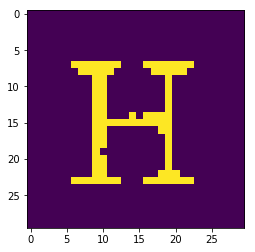

In [21]:
plt.imshow(np.reshape(ka[0], (30,30)))

In [26]:
letters[np.argmax(prediction)]

'V'